In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import csv
import random
import os
from functools import partial

In [2]:
from paths import CAR_IMAGES_DIR  # YOU NEED TO GO TO THE paths.py FILE AND PUT YOUR FOLDER OF IMAGES

In [3]:
INDIVIDUAL_IMG_PATHS = [CAR_IMAGES_DIR / image_name for image_name in os.listdir(CAR_IMAGES_DIR)]

In [17]:
print(INDIVIDUAL_IMG_PATHS[23])

/home/adrian/Documents/academia/UAB/year_3/vision_learning/project1/archive/images/Cars329.png


In [4]:
def binary_methods(image_path, method = 'simple'):
    image_org = cv.imread(str(image_path))

    # Convert the image from BGR to RGB
    image_rgb = cv.cvtColor(image_org, cv.COLOR_BGR2RGB)
    image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)

    blur = cv.GaussianBlur(image_gray, (5, 5), 0)

    if method == 'original':
        return image_rgb
    
    if method == 'simple':
        binary__image = cv.threshold(blur, 127, 255, 0)[1]

    elif method == 'adaptive':
        binary__image = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)

    elif method == 'otsu':
        _, binary__image = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    elif method == 'Gaus_otsu':
        _, binary__image = cv.threshold(blur, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    return binary__image

In [5]:
def plot_car():
    plt.figure(figsize=(15, 10))   # (width, height)
    methods = ['original', 'simple', 'adaptive', 'otsu', 'Gaus_otsu']
    
    for i in range(len(methods) * 3):
        pos = i % len(methods)
        if (pos == 0):
            image_path = random.choice(INDIVIDUAL_IMG_PATHS)
            
        image = binary_methods(image_path, method=methods[pos])
        plt.subplot(3, len(methods), i+1)
        plt.imshow(image, 'gray')
        plt.title(methods[pos])
        plt.xticks([]),plt.yticks([])
    
    plt.show()

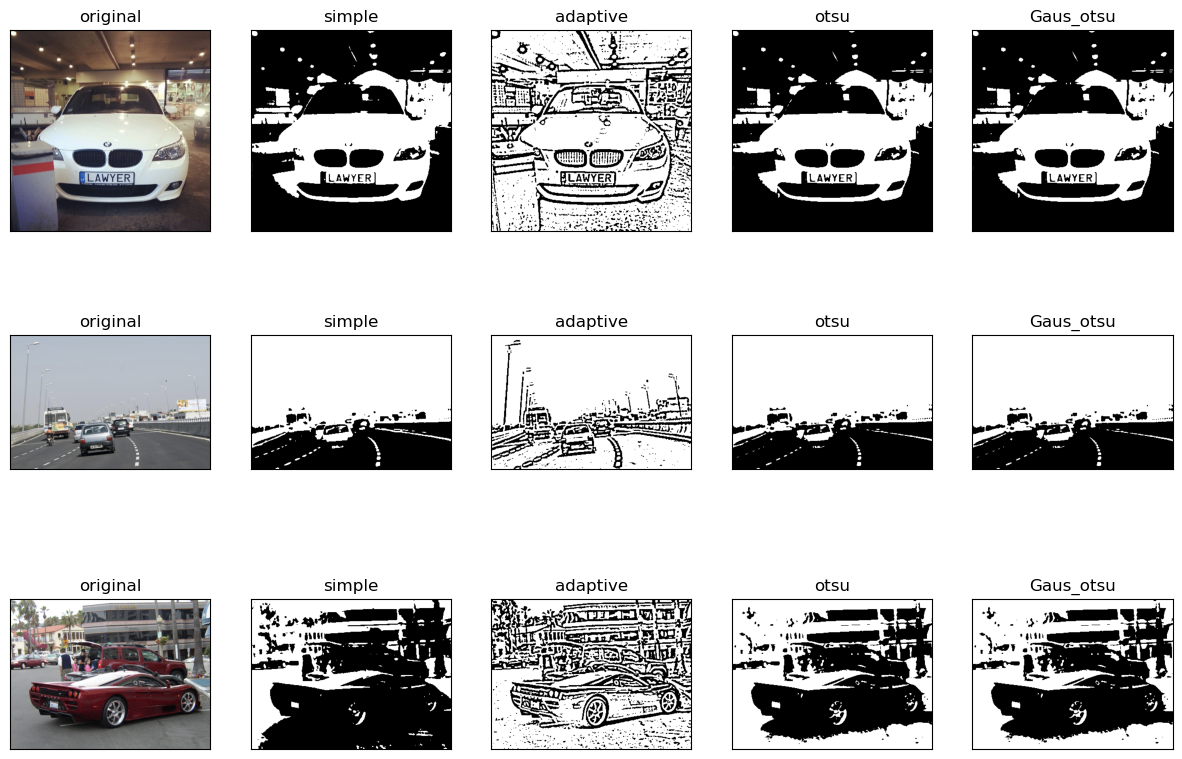

In [6]:
plot_car()

In [7]:
def mhorp_operations():
    pass

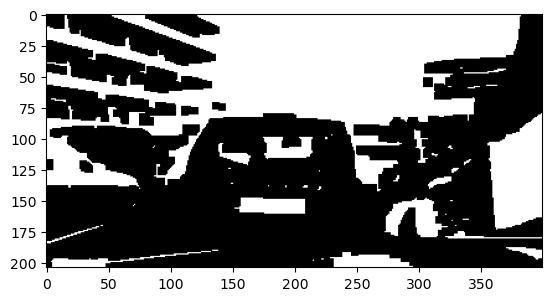

In [8]:
kernel = np.ones((6,6), np.uint8)  # 5x5 rectangular structuring element

image = cv.imread(str(INDIVIDUAL_IMG_PATHS[25]))

    # Convert the image from BGR to RGB
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
binary_image = cv.threshold(image_gray, 127, 255, 0)[1]

dilated_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)

plt.imshow(dilated_image, "gray")

In [9]:
canny = cv.Canny(dilated_image, 120, 255, 1)

# Find contours
cnts = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

crop_crd = dict()

# Iterate thorugh contours and draw rectangles around contours
for c in cnts:
    x,y,w,h = cv.boundingRect(c)
    cv.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    crop_crd[c.tostring()] = (x, y, w, h)

"""
cv.imshow('canny', canny)
cv.imshow('image', image)
cv.imwrite('canny.png', canny)
cv.imwrite('image.png', image)
cv.waitKey(0)
"""

/tmp/ipykernel_104442/1530192145.py:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  crop_crd[c.tostring()] = (x, y, w, h)


"\ncv.imshow('canny', canny)\ncv.imshow('image', image)\ncv.imwrite('canny.png', canny)\ncv.imwrite('image.png', image)\ncv.waitKey(0)\n"

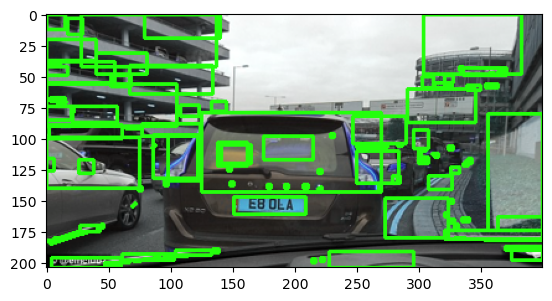

In [10]:
plt.imshow(image)

In [13]:
# List of lists which will be translated to the csv file
dataset_annotations = list()

# Iteration over all the images
for img_num, img_path in enumerate(INDIVIDUAL_IMG_PATHS):

    # Read the image
    image_org = cv.imread(str(INDIVIDUAL_IMG_PATHS[img_num]))

    """ | code to change (beta version) | """

    # Convert the image from BGR to RGB
    image_rgb = cv.cvtColor(image_org, cv.COLOR_BGR2RGB)
    image_gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    binary_image = cv.threshold(image_gray, 127, 255, 0)[1]

    # Morphological operators 
    dilated_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel)

    # Detector
    canny = cv.Canny(dilated_image, 120, 255, 1)

    # Find contours
    cnts = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    """ | code to change (beta version) | """

    # x, y, w, h, 0-1 for each cropped image. Whole information about all the detected rectangles on an image
    main_image = list()

    # First element on the list is the naming of the particular image
    main_image.append("Image" + str(img_num))

    # Iterate through contours and draw filled rectangles on the mask
    for c in cnts:

        # List for a single crop of the actual image
        crop = list()

        # Take the coordinates of the rectangle
        x, y, w, h = cv.boundingRect(c)
        # Append coordinates
        crop.append(x)
        crop.append(y)
        crop.append(w)
        crop.append(h)

        # Crop the image using the coordinates x, y, w, and h
        cropped_image = image_org[y:y+h, x:x+w]

        # Display the cropped image
        cv.imshow('Cropped Image', cropped_image)
        cv.waitKey(0)
        cv.destroyAllWindows()

        """ Control system to introduce a correct input """

        # Initialization

        # Set the boolean value of being a license to True or False. 0 || 1
        license_bool = int(input("(0 or 1) License? "))

        """ Control system to introduce a correct input """

        crop.append(license_bool)

        main_image.append(crop)

    # Append the main image to the dataset annotations in order to eventually pass it to the csv file
    dataset_annotations.append(main_image)

# Create the CSV file
with open('image_annotations.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dataset_annotations)

libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
